In [20]:
noisy_path = '../data/wav/noisy.wav'
noise_path = '../data/wav/noise.wav'
estim_path = '../data/wav/estim.wav'
clean_path = '../data/wav/clean.wav'

In [21]:
import torch
import librosa
import soundfile as sf
import numpy as np
import torch
import os,glob
import torchaudio.transforms as T

In [22]:
fft_size = 1024
shift_size = 256

## Load

In [23]:
noisy, sr = librosa.load(noisy_path,sr=16000)
print(np.shape(noisy))

(100578,)


## WAV2SPEC

In [24]:
torch_noisy = torch.from_numpy(noisy)
t1 = T.Spectrogram(n_fft = fft_size, hop_length= shift_size, center = False,power=None)
noisy_spec = t1(torch_noisy)
print(noisy_spec.shape)
print(noisy_spec)

torch.Size([513, 389, 2])
tensor([[[-1.3996e+00,  0.0000e+00],
         [-1.5314e+00,  0.0000e+00],
         [ 1.1386e+00,  0.0000e+00],
         ...,
         [-1.7270e-01,  0.0000e+00],
         [ 4.0452e-01,  0.0000e+00],
         [-1.0408e+00,  0.0000e+00]],

        [[-6.3967e-01, -1.2435e+00],
         [ 3.7087e+00,  1.1556e+00],
         [-4.1249e+00,  1.4343e+00],
         ...,
         [-5.3391e-01,  7.4937e+00],
         [ 3.3199e+00, -7.0069e+00],
         [-4.6760e+00,  5.2994e+00]],

        [[ 7.6219e-01, -1.1502e+00],
         [-6.4073e+00,  2.7481e+00],
         [ 8.3862e+00, -1.3455e+00],
         ...,
         [ 1.9660e+00, -2.2380e+01],
         [-8.5919e+00,  1.9632e+01],
         [ 1.5134e+01, -1.4583e+01]],

        ...,

        [[ 1.8076e-03, -8.9571e-05],
         [-3.4585e-03, -2.1577e-05],
         [ 1.7314e-03,  4.0603e-04],
         ...,
         [ 4.2248e-04, -4.1103e-04],
         [ 2.3746e-04, -1.6451e-04],
         [ 2.5749e-05,  4.4504e-04]],

        

In [25]:
noisy_mag = noisy_spec[:,:,0]**2 + noisy_spec[:,:,1]**2
print(noisy_mag.shape)
#print(noisy_mag)
noisy_pha = torch.angle(noisy_spec[:,:,0]+noisy_spec[:,:,1]*1j)
print(noisy_pha.shape)

torch.Size([513, 389])
torch.Size([513, 389])


## SPEC2MEL

In [26]:
t2 = T.MelScale(n_mels=80, sample_rate = sr)
noisy_mel = t2(noisy_mag)
print(noisy_mel.shape)

torch.Size([80, 389])


## MEL2SPEC

In [27]:
t3 = T.InverseMelScale(n_stft = int(fft_size/2 +1), n_mels = 80, sample_rate = sr, max_iter = 5000,tolerance_loss =1e-6)
noisy_inv_mag = t3(noisy_mel)
print(noisy_inv_mag.shape)
#print(noisy_inv_spec)

torch.Size([513, 389])


## SPEC2WAV

In [28]:
noisy_inv_mag = torch.unsqueeze(noisy_inv_mag,0)
noisy_pha = torch.unsqueeze(noisy_pha,0)
print(noisy_inv_mag.shape)
print(noisy_pha.shape)

tmp = noisy_inv_mag*torch.exp(noisy_pha*1j)
noisy_inv_spec= torch.zeros((tmp.shape[0],tmp.shape[1],tmp.shape[2],2))
print(noisy_inv_spec.shape)
print(tmp.real.shape)
noisy_inv_spec[:,:,:,0] = tmp.real
noisy_inv_spec[:,:,:,1] = tmp.imag


torch.Size([1, 513, 389])
torch.Size([1, 513, 389])
torch.Size([1, 513, 389, 2])
torch.Size([1, 513, 389])


In [29]:
noisy_inv_torch = torch.istft(noisy_inv_spec, n_fft = fft_size, hop_length= shift_size, center = False)
print(noisy_inv_torch.shape)

torch.Size([1, 99840])


## SAVE

In [34]:
noisy_inv_np = noisy_inv_torch.detach().cpu().numpy()
noisy_inv = noisy_inv_np/max(abs(noisy_inv_np))
noisy_inv = noisy_inv[0,:]
print(np.shape(noisy_inv))
sf.write('inv_noisy_torch.wav',noisy_inv,16000)

(99840,)


## Plot

In [35]:
import matplotlib.pyplot as plt

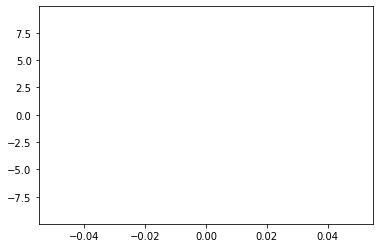

In [37]:
plt.plot(noisy_inv_np)
plt.show()

## MISC 